In [1]:
# Author: Riley Owens (GitHub: mrileyowens)

# This file fits a central peak to the Lyα
# velocity profile, subtracts it, and then 
# computes the velocity separation between 
# the two remaining peaks. Then, the FWHM
# of each component is calculated.

In [2]:
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=100
plt.rcParams['lines.linewidth']=0.5

from scipy.optimize import curve_fit

from lmfit.models import SkewedGaussianModel

In [3]:
def gaussFit(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
def fitNormPeak(vArr,fArr,sampleMin,sampleMax,params,bounds):

    fArr=fArr[vArr > sampleMin]
    vArr=vArr[vArr > sampleMin]
    fArr=fArr[vArr < sampleMax]
    vArr=vArr[vArr < sampleMax]

    popt,pcov=curve_fit(gaussFit,vArr,fArr,p0=params,bounds=bounds)

    return popt,pcov

def centroid(vArr,fArr,Min,Max):
    
    mask=((vArr>Min) & (vArr<Max)).astype(int)
    fArrMask=fArr*mask
    i=np.argmax(fArrMask)
    a1=(fArrMask[i+1]-fArrMask[i-1])/2
    a2=(fArrMask[i+1]+fArrMask[i-1]-2*fArrMask[i])/2
    
    ctrPix=i-(a1/(2*a2))
    
    ctr=((vArr[-1]-vArr[-2])*(ctrPix-i))+vArr[i]
    
    return ctr

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y, Min, Max):
    
    y=y[x > Min]
    x=x[x > Min]
    y=y[x < Max]
    x=x[x < Max]
    
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    print(zero_crossings_i)
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)],half

def v2w(v,redshift):
    
    w=1215.67*(1.0+redshift)*(1.0+(v/3e5))
    
    return w

def cont(wArr,fArr,Min,Max):
    
    fArr=fArr[wArr > Min]
    wArr=wArr[wArr > Min]
    fArr=fArr[wArr < Max]
    wArr=wArr[wArr < Max]
    
    cont=np.mean(fArr)
    
    return cont

In [4]:
# Establishing directories and filepaths
home='C://Users/15136/OneDrive - University of Cincinnati/Documents/Research/sunburstarc'
data=home+'/data/spectra/mage'
figs=home+'/figs'

spectra=data+'/planckarc_pos1-comb1_MWdr.txt'

In [5]:
redshift=2.37067

In [6]:
# Setting plot labels
title='Slit 1'
wlabel='Wavelength (Å)'
vlabel='Velocity (km s$^{-1}$)'
flabel='Flux (10$^{-27}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)'

In [7]:
#Converting .txt file into a data frame
dataFrame=pd.read_csv(spectra,delimiter='\t',header=0,skiprows=13)

#Discarding missing data
dataFrame=dataFrame.apply(pd.to_numeric,errors='coerce').dropna()

#Discarding extreme outliers
dataFrame=dataFrame[dataFrame.iloc[:,1]<1e-20]

#Resetting the index
dataFrame=dataFrame.reset_index(drop=True)

# Extracting wavelength, flux, and noise
wArr=dataFrame.iloc[:,0].to_numpy()
fArr=dataFrame.iloc[:,1].to_numpy()
nArr=dataFrame.iloc[:,2].to_numpy()

# Converting wavelength to peculiar velocity
# of Lyman-α line
vArr=(3e5)*(((wArr/(1+redshift))/1215.67)-1)

Text(0, 0.5, 'Flux (10$^{-27}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')

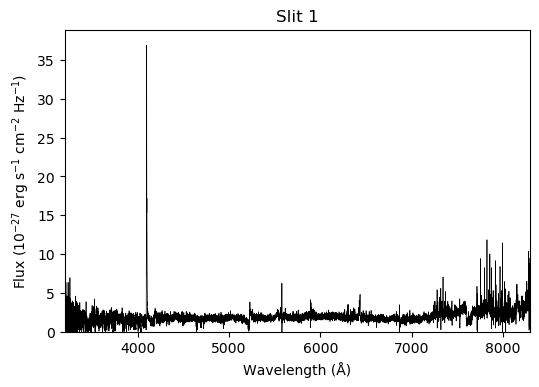

In [8]:
# Plotting moving-frame spectrum
plt.close('all')
fig,ax=plt.subplots(1,1)

plt.plot(wArr,fArr*1e27,color='black',drawstyle='steps-mid')
ax.set_xlim(wArr[0],wArr[-1])
ax.set_ylim(0.0)
plt.title(title)
ax.set_xlabel(wlabel)
ax.set_ylabel(flabel)

Text(0, 0.5, 'Flux (10$^{-27}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')

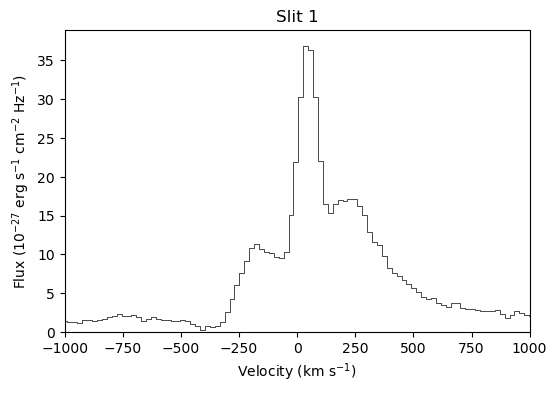

In [9]:
# Plotting the Lyα profile in its peculiar velocity space
plt.close('all')
fig,ax=plt.subplots(1,1)

plt.plot(vArr,fArr*1e27,color='black',drawstyle='steps-mid')
ax.set_xlim(-1000.0,1000.0)
ax.set_ylim(0.0)
plt.title(title)
ax.set_xlabel(vlabel)
ax.set_ylabel(flabel)

In [10]:
# Fitting a narrow portion of the central peak as a Gaussian
popt,pcov=fitNormPeak(vArr,fArr*1e27,10.0,70.0,params=(35.0,50.0,20),bounds=(-np.inf,np.inf))

c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0, 0.5, 'Flux (10$^{-27}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')

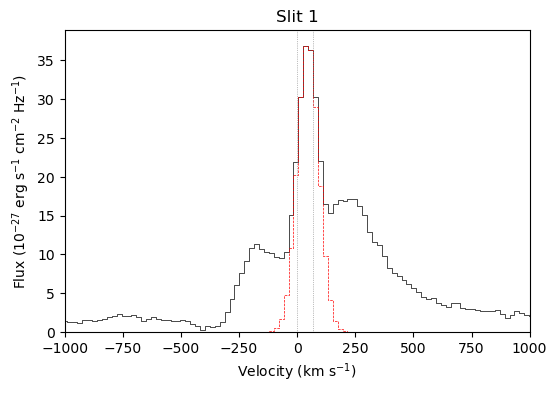

In [11]:
# Overplotting the Gaussian fit on the Lyα profile
plt.close('all')
fig,ax=plt.subplots(1,1)

plt.plot(vArr,fArr*1e27,color='black',drawstyle='steps-mid')
plt.plot(vArr,gaussFit(vArr,*popt),color='red',drawstyle='steps-mid',linestyle='dashed')
ax.axvline(0.0,color='gray',linestyle='dotted')
ax.axvline(70.0,color='gray',linestyle='dotted')
ax.set_xlim(-1000.0,1000.0)
ax.set_ylim(0.0)
plt.title(title)
ax.set_xlabel(vlabel)
ax.set_ylabel(flabel)

Text(0, 0.5, 'Flux (10$^{-27}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')

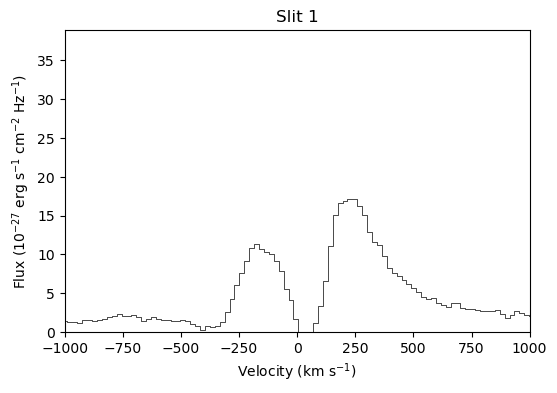

In [12]:
# Plotting the red/blueshifted peaks after subtracting the central peak's fit
plt.close('all')
fig,ax=plt.subplots(1,1)

plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt),color='black',drawstyle='steps-mid')
plt.plot(vArr,fArr*1e27,alpha=0.0,drawstyle='steps-mid')
ax.set_xlim(-1000.0,1000.0)
ax.set_ylim(0.0)
plt.title(title)
ax.set_xlabel(vlabel)
ax.set_ylabel(flabel)

In [13]:
# Computing the centroids of the red and blueshifted peaks
ctrB=centroid(vArr,fArr*1e27-gaussFit(vArr,*popt),-250.0,20.0)
ctrR=centroid(vArr,fArr*1e27-gaussFit(vArr,*popt),50.0,500.0)

print(ctrR,ctrB)
print(ctrR-ctrB)

241.26334667997523 -176.49335920652322
417.7567058864985


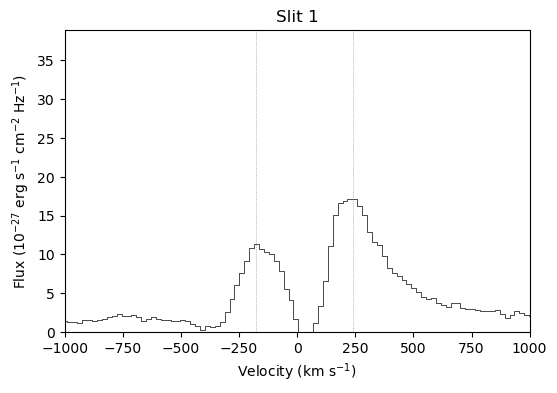

In [14]:
# Plotting the red/blueshifted peaks against their computed centroids
plt.close('all')
fig,ax=plt.subplots(1,1)

plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt),color='black',drawstyle='steps-mid')
plt.plot(vArr,fArr*1e27,alpha=0.0,drawstyle='steps-mid')
ax.axvline(ctrB,c='gray',ls='dotted')
ax.axvline(ctrR,c='gray',ls='dotted')
ax.set_xlim(-1000.0,1000.0)
ax.set_ylim(0.0)
plt.title(title)
ax.set_xlabel(vlabel)
ax.set_ylabel(flabel)

plt.savefig(figs+'/1ctr.png',dpi=100)

In [15]:
# Averaging the local continuum
cntm=cont(wArr,fArr*1e27,4081.0,4086.0)

In [16]:
# Computing velocity-space FWHM and half-max
hmxB,halfB=half_max_x(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,-400.0,50.0)
hmxR,halfR=half_max_x(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,10.0,750.0)
hmxC,halfC=half_max_x(vArr,gaussFit(vArr,*popt)-cntm,-1000.0,1000.0)

#hmxR,halfR=half_max_x(vArr,fArr*1e27-cntm,10.0,750.0)

[ 6 15]
[ 5 17]
[46 51]


Text(0, 0.5, 'Flux (10$^{-27}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)')

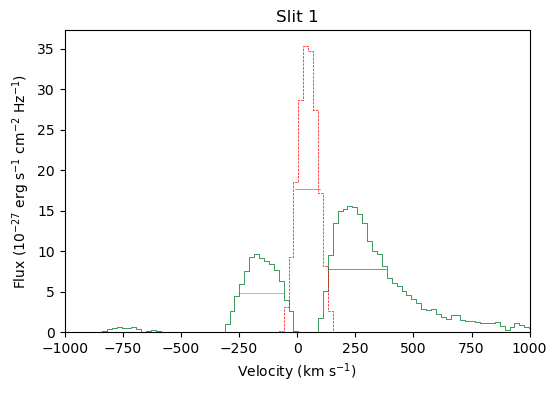

In [17]:
# Plotting each component with its FWHM
plt.close('all')
fig,ax=plt.subplots(1,1)

plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,ds='steps-mid')
plt.plot(hmxB, [halfB, halfB])

plt.plot(vArr,fArr*1e27-gaussFit(vArr,*popt)-cntm,ds='steps-mid')
plt.plot(hmxR, [halfR, halfR])

plt.plot(vArr,gaussFit(vArr,*popt)-cntm,ds='steps-mid',ls='dashed',c='red')
plt.plot(hmxC,[halfC,halfC])

ax.set_xlim(-1000.0,1000.0)
ax.set_ylim(0.0)
plt.title(title)
ax.set_xlabel(vlabel)
ax.set_ylabel(flabel)

In [18]:
# Converting FWHM to wavelength-space
fwhmRw=v2w(hmxR[1],redshift)-v2w(hmxR[0],redshift)
fwhmCw=v2w(hmxC[1],redshift)-v2w(hmxC[0],redshift)
fwhmBw=v2w(hmxB[1],redshift)-v2w(hmxB[0],redshift)

fwhmRv=hmxR[1]-hmxR[0]
fwhmCv=hmxC[1]-hmxC[0]
fwhmBv=hmxB[1]-hmxB[0]

print("fwhmRw:{:.10f}".format(fwhmRw))
print("fwhmCw:{:.10f}".format(fwhmCw))
print("fwhmBw:{:.10f}".format(fwhmBw))

print("fwhmRv:{:.10f}".format(fwhmRv))
print("fwhmCv:{:.10f}".format(fwhmCv))
print("fwhmBv:{:.10f}".format(fwhmBv))

fwhmRw:3.3688256171
fwhmCw:1.4584770637
fwhmBw:2.7038909234
fwhmRv:246.6424640270
fwhmCv:106.7797557951
fwhmBv:197.9604751366
